# Notebook for Stroke Risk Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### Pre-processing

In [2]:
q2 = pd.read_csv('cleaned_data_part2.csv')

In [3]:
q2.fillna(q2.median(), inplace=True)
q2.drop(columns=['BPAOARM', 'SLQ300', 'SLQ310', 'SLQ320', 'SLQ330'], inplace=True)
q2 = q2.loc[q2['MCQ160F']!=9]
q2.loc[q2['MCQ160F']==1, 'y'] = 1
q2.loc[q2['MCQ160F']==2, 'y'] = 0
q2.drop(columns='MCQ160F', inplace=True)

In [4]:
q2.y.value_counts()

0.0    14015
1.0      760
Name: y, dtype: int64

In [5]:
q2

,SEQN,ALQ111,ALQ121,ALQ151,BMDSTATS,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,...,WHQ030,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD140,WHQ150,y
0,109266.0,1.0,1.000000e+01,2.0,1.0,97.1,160.2,37.8,40.8,34.7,...,1.0,2.0,200.0,1.0,2.0,170.0,210.0,218.0,28.0,0.0
1,109271.0,1.0,5.397605e-79,1.0,1.0,98.8,182.3,29.7,40.1,42.0,...,3.0,3.0,180.0,2.0,4.0,280.0,350.0,350.0,24.0,0.0
2,109273.0,1.0,5.397605e-79,2.0,1.0,74.3,184.2,21.9,41.0,41.1,...,2.0,1.0,155.0,2.0,2.0,150.0,155.0,300.0,16.0,0.0
3,109274.0,1.0,4.000000e+00,2.0,1.0,103.7,185.3,30.2,44.0,47.0,...,1.0,2.0,230.0,2.0,1.0,240.0,190.0,270.0,54.0,0.0
4,109282.0,1.0,5.397605e-79,2.0,3.0,83.3,177.1,26.6,39.0,40.0,...,1.0,2.0,175.0,2.0,5.0,175.0,135.0,208.0,33.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14796,102740.0,1.0,5.000000e+00,2.0,1.0,79.6,166.1,28.7,39.0,37.5,...,1.0,2.0,375.0,2.0,1.0,240.0,200.0,385.0,60.0,0.0
14797,102804.0,1.0,5.000000e+00,2.0,1.0,79.6,166.1,28.7,39.0,37.5,...,1.0,2.0,260.0,1.0,2.0,170.0,240.0,272.0,29.0,0.0
14798,102825.0,1.0,5.000000e+00,2.0,1.0,79.6,166.1,28.7,39.0,37.5,...,1.0,2.0,170.0,2.0,2.0,185.0,120.0,185.0,75.0,0.0
14799,102940.0,1.0,5.000000e+00,2.0,1.0,79.6,166.1,28.7,39.0,37.5,...,1.0,2.0,193.0,2.0,4.0,7777.0,185.0,7777.0,40.0,1.0


### EDA

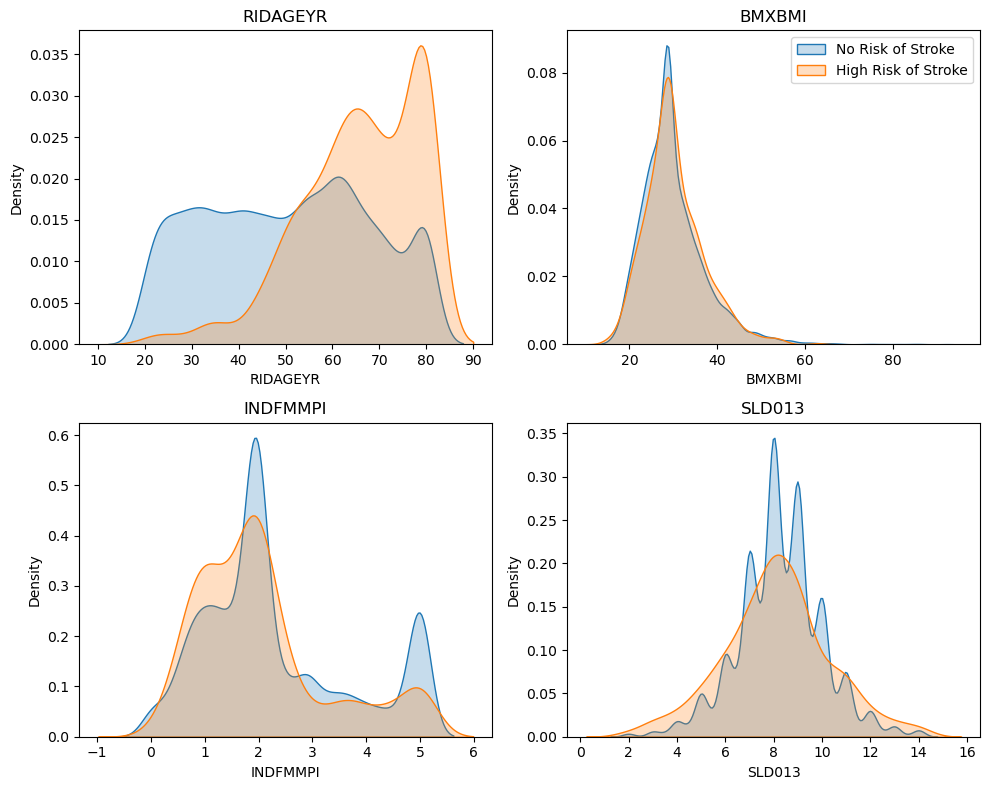

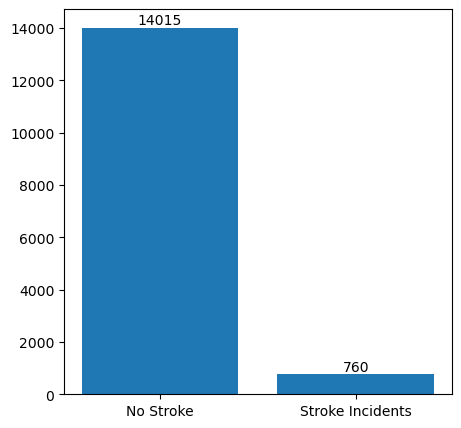

In [6]:
import seaborn as sns

plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(q2[['RIDAGEYR', 'BMXBMI', 'INDFMMPI', 'SLD013']].columns[:4]):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(q2.loc[q2['y'] == 0, col], shade=True, label='No Risk of Stroke')
    sns.kdeplot(q2.loc[q2['y'] == 1, col], shade=True, label='High Risk of Stroke')
    # plt.xlabel('cm')
    plt.title(col)
    if i == 1:
        plt.legend(loc='upper right')
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()

y_vals = ['No Stroke','Stroke Incidents']
y_counts = [14015, 760]
plt.figure(figsize=(5,5))
plt.bar(y_vals, y_counts)
for i in range(len(y_vals)):
    plt.text(y_vals[i], y_counts[i], str(y_counts[i]), ha='center', va='bottom')


## Getting Feature Importance and Results using Logistic Regression with LASSO and 5-fold CV

In [7]:
X = q2.copy()
X.drop(columns='y', inplace=True)
X.drop(columns='SEQN', inplace=True)
feature_names = X.columns
y = q2.y
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

c_vals = [0.01, 0.05, 0.1, 0.5, 1, 10]
log = LogisticRegressionCV(Cs=c_vals, cv=5, penalty='l1', solver='liblinear', refit=True, random_state=2, verbose=False, max_iter=100)
log.fit(X_train, y_train)

lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=2)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
rep = metrics.classification_report(y_test, y_pred)

In [8]:
log.C_

array([0.01])

In [9]:
auc

0.5159952535448209

In [10]:
acc

0.9458581483486735

In [11]:
f1

0.06542056074766354

In [12]:
confusion_matrix

array([[3487,   17],
       [ 183,    7]])

In [13]:
print(rep)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      3504
         1.0       0.29      0.04      0.07       190

    accuracy                           0.95      3694
   macro avg       0.62      0.52      0.52      3694
weighted avg       0.92      0.95      0.93      3694



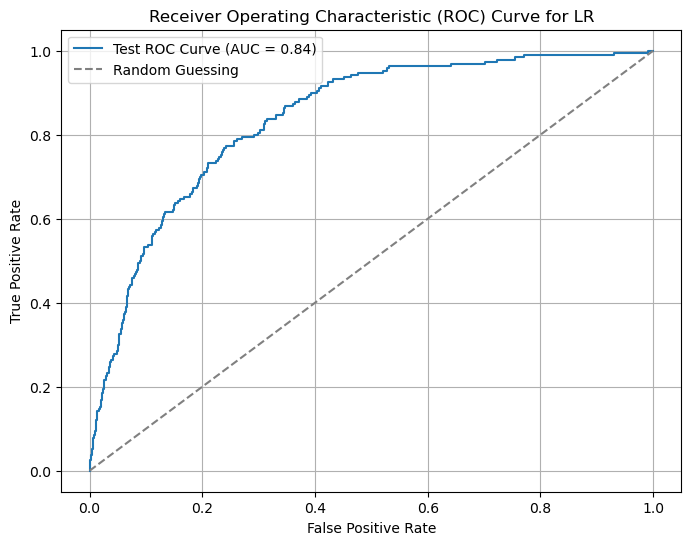

In [14]:
y_probas_test = lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_probas_test)
auc_test = metrics.auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LR')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
f = pd.DataFrame(log.feature_names_in_)
b = pd.DataFrame(log.coef_[0])
fb = pd.concat([f,b], axis=1)
fb.columns = ['f', 'b']
fb['bb'] = abs(fb['b'])
fb.sort_values('bb', ascending=False, inplace=True)
fb[fb.bb>0]

,f,b,bb
87,OCD150,0.238842,0.238842
12,BPQ020,-0.122276,0.122276
99,SLQ120,0.054974,0.054974
56,KIQ005,0.050557,0.050557
47,INDFMPIR,-0.049644,0.049644
29,RIDAGEYR,0.036734,0.036734
53,INDFMMPC,-0.032316,0.032316
60,KIQ480,0.022833,0.022833
22,BPXODI3,0.017327,0.017327
46,SDMVSTRA,-0.016863,0.016863


## Getting Feature Importance using Random Forest Classifier and XGBoost Classifier

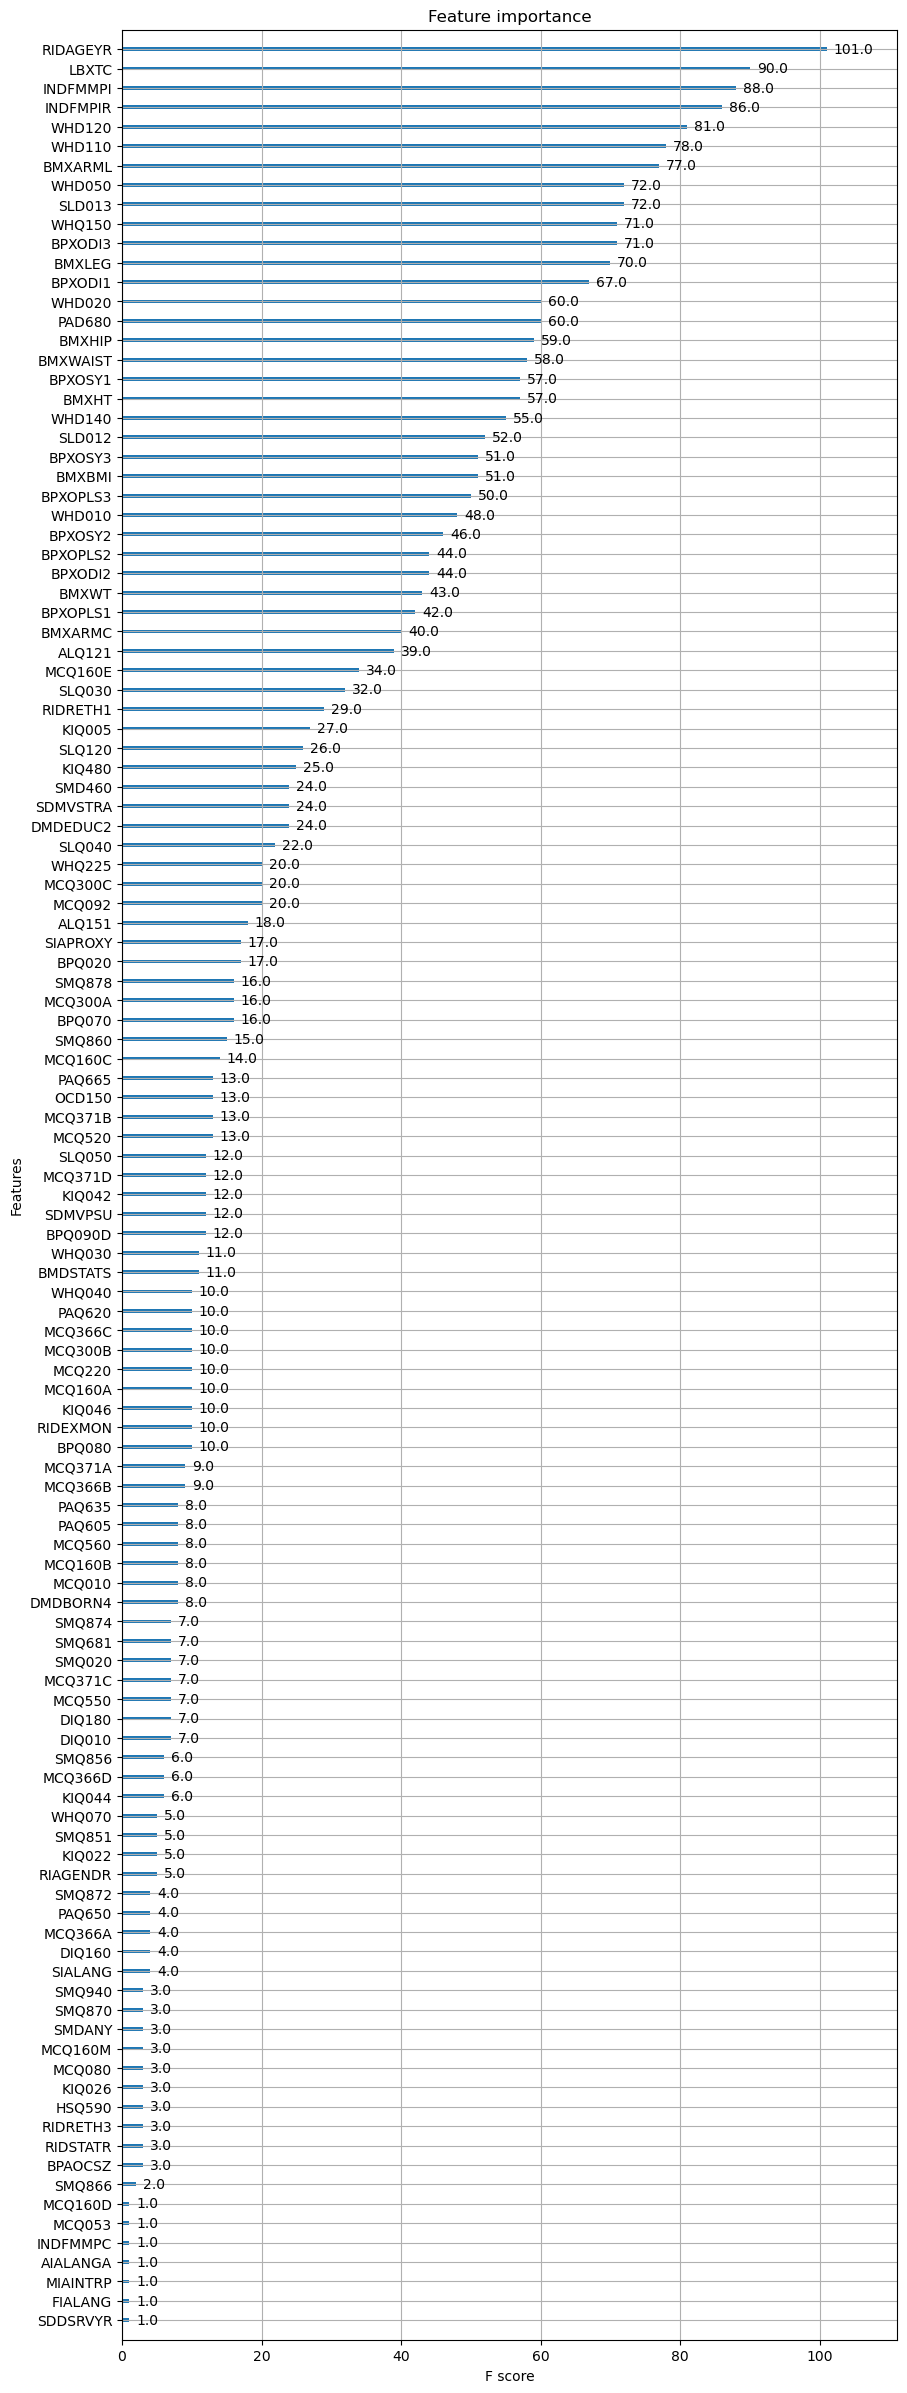

Text(0, 0.5, 'Mean decrease in impurity')

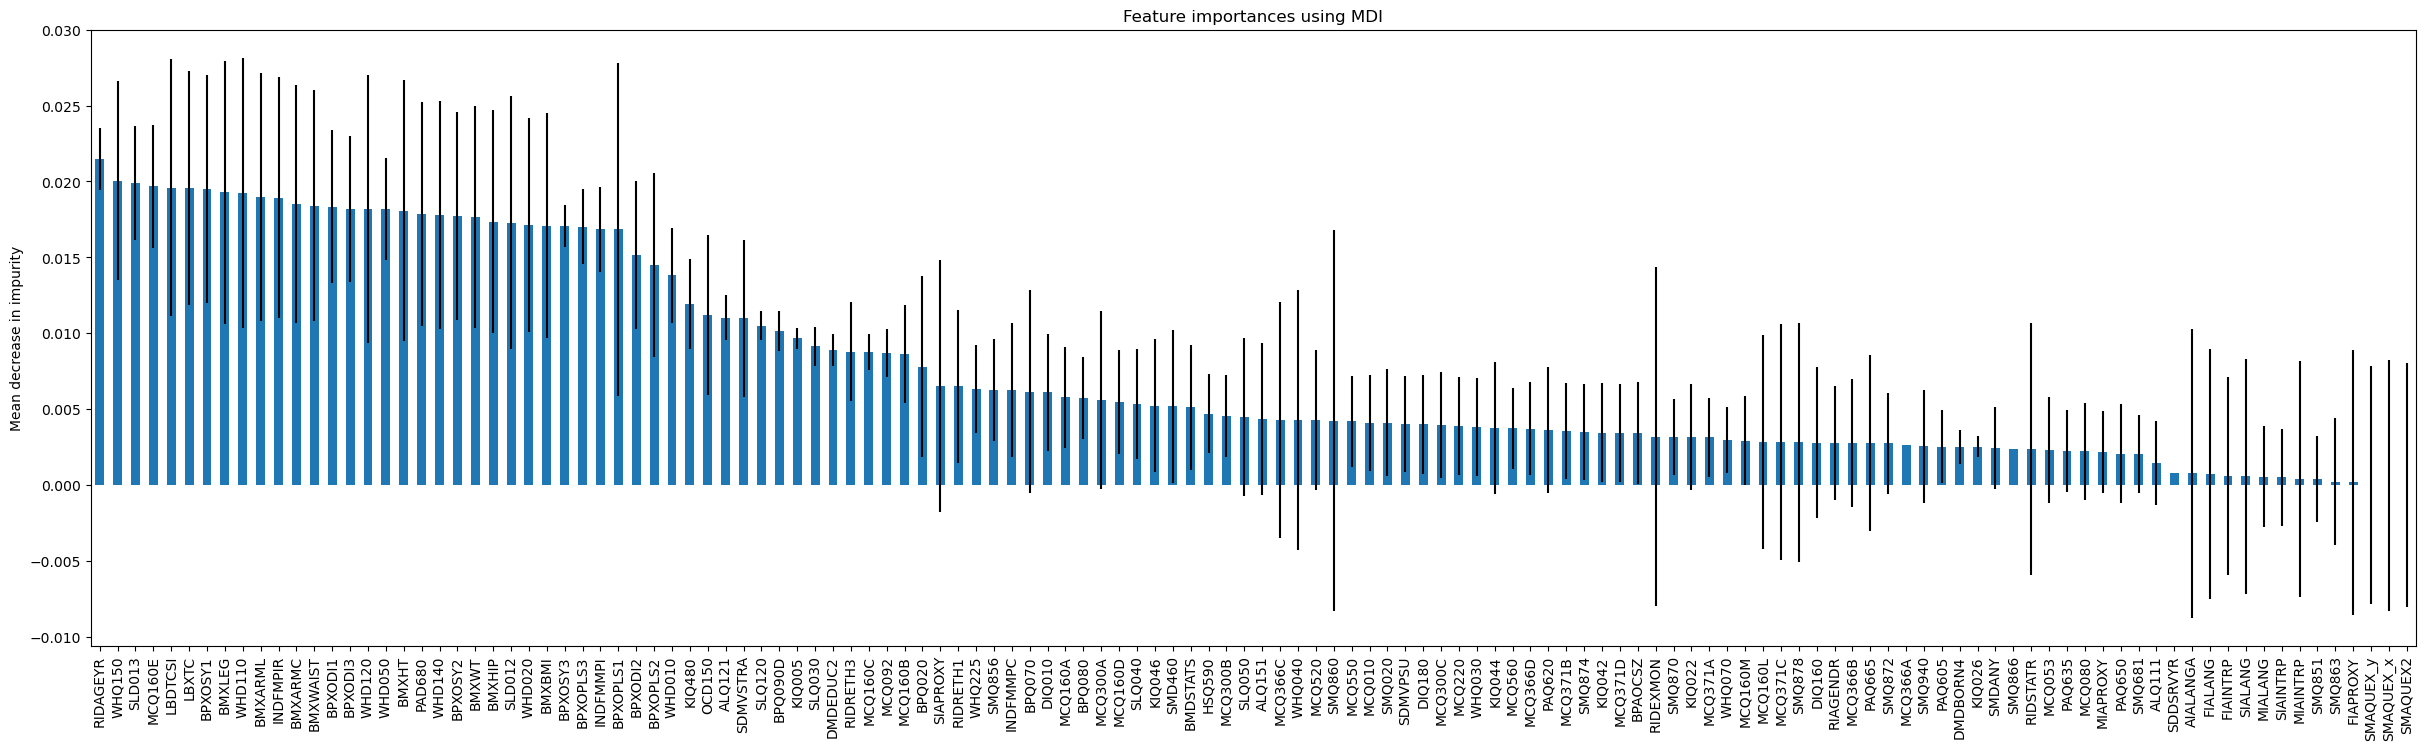

In [16]:
X = q2.copy()
X.drop(columns='y', inplace=True)
X.drop(columns='SEQN', inplace=True)
feature_names = X.columns
y = q2.y



X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#######################
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(X_train, y_train)
xgb_imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_imp.sort_values(ascending=False, inplace=True)

plt.rcParams["figure.figsize"] = (10, 30)
plot_importance(xgb_model)
plt.show()
#######################

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

imp = pd.Series(forest.feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False, inplace=True)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(30, 8))
imp.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

##### Comparing the top 50 most important features from both classifiers and using the common ones for modeling

In [17]:
df = pd.DataFrame(xgb_model.get_booster().get_score(importance_type = "weight"), index = ["raw_importance"]).T
df.sort_values('raw_importance',ascending=False, inplace=True)
rf_imp_50 = [imp[:50].index]
xgb_imp_50 = [df.iloc[:50,:].index]

ind = []
for _ in range(50):
    if rf_imp_50[0][_] in xgb_imp_50[0]:
        ind.append(rf_imp_50[0][_])
ind

['RIDAGEYR',
 'WHQ150',
 'SLD013',
 'MCQ160E',
 'LBXTC',
 'BPXOSY1',
 'BMXLEG',
 'WHD110',
 'BMXARML',
 'INDFMPIR',
 'BMXARMC',
 'BMXWAIST',
 'BPXODI1',
 'BPXODI3',
 'WHD120',
 'WHD050',
 'BMXHT',
 'PAD680',
 'WHD140',
 'BPXOSY2',
 'BMXWT',
 'BMXHIP',
 'SLD012',
 'WHD020',
 'BMXBMI',
 'BPXOSY3',
 'BPXOPLS3',
 'INDFMMPI',
 'BPXOPLS1',
 'BPXODI2',
 'BPXOPLS2',
 'WHD010',
 'KIQ480',
 'ALQ121',
 'SDMVSTRA',
 'SLQ120',
 'KIQ005',
 'SLQ030',
 'DMDEDUC2',
 'MCQ092',
 'BPQ020',
 'SIAPROXY',
 'RIDRETH1',
 'WHQ225']

## Running the XGBoost model on selected features

In [18]:
X = q2.copy()
X = X[ind]
y = q2.y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

cat_features = ['MCQ160E', 'BPQ020', 'SLQ120', 'SLQ030', 'MCQ092', 'DMDEDUC2', 'KIQ005', 'RIDRETH1', 'SIAPROXY'] # BPQ090D
num_features = [col for col in X_train.columns if col not in cat_features]

###############

###############

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[cat_features])
X_test_encoded = encoder.transform(X_test[cat_features])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(cat_features))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(cat_features))

X_train.reset_index(drop=True, inplace=True)
X_train_encoded_df.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

X_train_final = pd.concat([X_train[num_features], X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test[num_features], X_test_encoded_df], axis=1)

# ct = ColumnTransformer([
#         ('somename', MinMaxScaler(), num_features)
#     ], remainder='passthrough')

# X_train_scaled = ct.fit_transform(X_train_final)
# X_test_scaled = ct.transform(X_test_final)

# sm = SMOTE(random_state = 2)
# X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train.ravel())

xgb_model = XGBClassifier(random_state = 0 )

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) ##
cv_scores = cross_val_score(xgb_model, X_train_final, y_train, cv=cv, scoring='accuracy') ##
xgb_model.fit(X_train_final, y_train)

y_pred = xgb_model.predict(X_test_final)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred )
auc = metrics.auc(fpr, tpr)
acc = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
rep = metrics.classification_report(y_test, y_pred)

In [19]:
confusion_matrix

array([[3494,   10],
       [  96,   94]])

In [20]:
auc

0.7459414804133622

In [21]:
f1

0.6394557823129251

In [22]:
acc

0.971304818624797

In [23]:
cv_scores

array([0.9706811 , 0.96886282, 0.96886282, 0.97066787, 0.97111913])

In [24]:
print(rep)

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      3504
         1.0       0.90      0.49      0.64       190

    accuracy                           0.97      3694
   macro avg       0.94      0.75      0.81      3694
weighted avg       0.97      0.97      0.97      3694



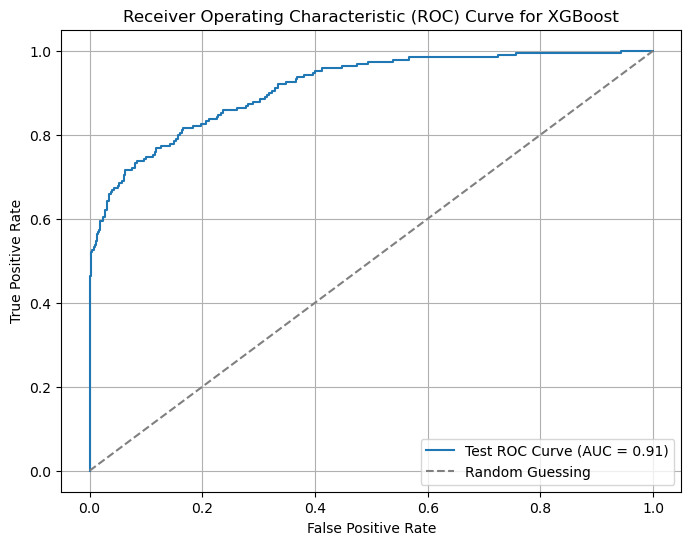

In [25]:
y_probas_test = xgb_model.predict_proba(X_test_final)[:, 1]

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_probas_test)
auc_test = metrics.auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend()
plt.grid(True)
plt.show()